In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, Flatten, Dense, LeakyReLU, Conv2DTranspose, Reshape, Activation
from keras.models import Model
from keras import backend as K
from keras.callbacks import Callback, LearningRateScheduler
from keras.callbacks import ModelCheckpoint 
from keras.optimizers import Adam
from keras.datasets import mnist
import os
from google.colab import drive

Using TensorFlow backend.


In [2]:
# Bit ugly, but works for now
try:
  os.listdir('/content/gdrive/My Drive/')
except:
  drive.mount('/content/gdrive')

In [3]:
save_path = '/content/gdrive/My Drive/data/models/'
model_name = 'autoencoder_mnist_basic'
model_save_path = save_path + model_name + '_model.kerasmodel'
weights_save_path = save_path + model_name + '_weights.h5'
print(f"model save path: {model_save_path}")
print(f"weights save path: {weights_save_path}")

model save path: /content/gdrive/My Drive/data/models/autoencoder_mnist_basic_model.kerasmodel
weights save path: /content/gdrive/My Drive/data/models/autoencoder_mnist_basic_weights.h5


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

Create encoder model

In [5]:
encoder_input = Input((28, 28, 1))

e = Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same'
    )(encoder_input)
e = LeakyReLU()(e)

e = Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    padding='same'
    )(e)
e = LeakyReLU()(e)

e = Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    padding='same'
    )(e)
e = LeakyReLU()(e)

e = Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same'
    )(e)
e = LeakyReLU()(e)

shape_before_flattening = K.int_shape(e)[1:]

e = Flatten()(e)
encoder_output = Dense(2)(e)

encoder_model = Model(encoder_input, encoder_output)

encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0   

Create decoder model

In [6]:
decoder_input = Input((2,))

d = Dense(np.prod(shape_before_flattening))(decoder_input)
d = Reshape(shape_before_flattening)(d)

d = Conv2DTranspose(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same'
    )(d)
d = LeakyReLU()(d)

d = Conv2DTranspose(
    filters=64,
    kernel_size=3,
    strides=2,
    padding='same'
    )(d)
d = LeakyReLU()(d)

d = Conv2DTranspose(
    filters=32,
    kernel_size=3,
    strides=2,
    padding='same'
    )(d)
d = LeakyReLU()(d)

d = Conv2DTranspose(
    filters=1,
    kernel_size=3,
    strides=1,
    padding='same'
    )(d)
d = Activation('sigmoid')(d)

decoder_output = d

decoder_model = Model(decoder_input, decoder_output)

decoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0   

Full autoencoder

In [7]:
ae_input = encoder_input
ae_output = decoder_model(encoder_output)

ae_model = Model(ae_input, ae_output)

Training

In [8]:
LEARNING_RATE = 0.0005
LEARNING_RATE_DECAY = 1
BATCH_SIZE = 32
EPOCHS = 200
INITIAL_EPOCH = 0

In [9]:
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

In [10]:
optimizer = Adam(lr=LEARNING_RATE)
ae_model.compile(optimizer=optimizer, loss=r_loss)

In [11]:
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr

    return LearningRateScheduler(schedule)

In [12]:
class CustomCallback(Callback):    
    def __init__(self):
        self.losses = []
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        #keys = list(logs.keys())
        #print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        self.lrs.append(logs['lr'])
        self.losses.append(logs['loss'])

In [13]:
lr_sched = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=LEARNING_RATE_DECAY, step_size=1)
checkpoint = ModelCheckpoint(weights_save_path, save_weights_only=True, verbose=0)
cb = CustomCallback()

In [14]:
ae_model.fit(     
    x_train,
    x_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    epochs=EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[lr_sched, checkpoint, cb]
    )

Epoch 1/200
60000/60000 [==============================] - 15s 254us/step - loss: 0.0557
Epoch 2/200
60000/60000 [==============================] - 13s 211us/step - loss: 0.0459
Epoch 3/200
60000/60000 [==============================] - 12s 206us/step - loss: 0.0441
Epoch 4/200
60000/60000 [==============================] - 12s 206us/step - loss: 0.0430
Epoch 5/200
60000/60000 [==============================] - 13s 213us/step - loss: 0.0423
Epoch 6/200
60000/60000 [==============================] - 13s 221us/step - loss: 0.0418
Epoch 7/200
60000/60000 [==============================] - 13s 213us/step - loss: 0.0414
Epoch 8/200
60000/60000 [==============================] - 13s 213us/step - loss: 0.0411
Epoch 9/200
60000/60000 [==============================] - 13s 210us/step - loss: 0.0408
Epoch 10/200
60000/60000 [==============================] - 13s 215us/step - loss: 0.0406
Epoch 11/200
60000/60000 [==============================] - 13s 216us/step - loss: 0.0404
Epoch 12/200
60000/

In [15]:
ae_model.save(model_save_path)

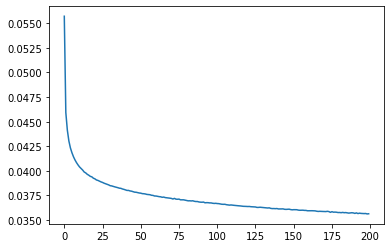

In [16]:
plt.plot(cb.losses)